In [141]:

import sys
import pandas as pd
import numpy as np
import warnings
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from tslearn.clustering import TimeSeriesKMeans
from tslearn.preprocessing import TimeSeriesScalerMeanVariance
from scipy.ndimage.filters import gaussian_filter1d
from scipy.interpolate import interp1d
from kneed import KneeLocator
from tslearn.utils import to_time_series_dataset
import mlflow
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import shap

sys.path.append('../../..')

RANDOM_STATE=42

pd.options.display.max_columns = None
warnings.filterwarnings("ignore")

In [142]:
df = pd.read_parquet('../../../datasets/processed/competencia_02_Miranda_Wind_Tour.parquet')

In [143]:
df[df["numero_de_cliente"] == np.random.choice(df["numero_de_cliente"].unique())].tail(5)

,numero_de_cliente,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,cproductos,tcuentas,ccuenta_corriente,mcuenta_corriente_adicional,mcuenta_corriente,ccaja_ahorro,mcaja_ahorro,mcaja_ahorro_adicional,mcaja_ahorro_dolares,cdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cinversion1,minversion1_pesos,minversion1_dolares,cinversion2,minversion2,cseguro_vida,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,cpayroll_trx,mpayroll,mpayroll2,cpayroll2_trx,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,ctarjeta_master_debitos_automaticos,mttarjeta_master_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,ccajeros_propios_descuentos,mcajeros_propios_descuentos,ctarjeta_visa_descuentos,mtarjeta_visa_descuentos,ctarjeta_master_descuentos,mtarjeta_master_descuentos,ccomisiones_mantenimiento,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,cforex,cforex_buy,mforex_buy,cforex_sell,mforex_sell,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,tcallcenter,ccallcenter_transacciones,thomebanking,chomebanking_transacciones,ccajas_transacciones,ccajas_consultas,ccajas_depositos,ccajas_extracciones,ccajas_otras,catm_trx,matm,catm_trx_other,matm_other,ctrx_quarter,tmobile_app,cmobile_app_trx,Master_delinquency,Master_status,Master_mfinanciacion_limite,Master_Fvencimiento,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_cconsumos,Master_cadelantosefectivo,Master_mpagominimo,Visa_delinquency,Visa_status,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,rank_foto_mes,rank_foto_mes_2,clase_ternaria,foto_mes
207676,130692348,0,0,0,27,42,0.00,0.00,0.00,0.00,0.00,6,1,1,0.0,0.00,2,147.62,0.0,4.96,1,0.00,1,0,0.00,1,0,0.00,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.00,0,0,0.0,0,0.0,2,4222.8,1,1173.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,0,0,0,0,0,0,0,0,0.0,0,0.0,6,0,0,0.0,0.0,88678.8,-1675.0,NaN,0.0,0.0,0.0,NaN,NaN,98532.0,NaN,NaN,-1.0,0.0,NaN,NaN,1254.0,NaN,NaN,NaN,0.0,0.0,0.0,88678.8,-2040.0,NaN,2573.74,3018.99,0.0,0.0,0.0,98532.0,0.0,0.0,-1.0,0.0,-3018.99,0.0,1254.0,0.0,0.0,0.0,293.25,5,-4,CONTINUA,2020-06-30
207677,130692348,1,0,1,28,43,-20.48,-3278.11,62.63,-82.51,11.65,6,1,1,0.0,0.00,2,774.18,0.0,5.09,1,83.48,1,0,0.00,1,2,3018.99,1,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00,2,62.63,0,0,0.0,0,0.0,1,3049.8,0,0.00,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0,1,8,0,0,0,0,0,0,0.0,0,0.0,8,0,0,0.0,0.0,88678.8,-1644.0,

In [144]:
df["foto_mes"].unique()

array([datetime.date(2019, 1, 31), datetime.date(2019, 2, 28),
       datetime.date(2019, 3, 31), datetime.date(2019, 4, 30),
       datetime.date(2019, 5, 31), datetime.date(2019, 6, 30),
       datetime.date(2019, 7, 31), datetime.date(2019, 8, 31),
       datetime.date(2019, 9, 30), datetime.date(2019, 10, 31),
       datetime.date(2019, 11, 30), datetime.date(2019, 12, 31),
       datetime.date(2020, 1, 31), datetime.date(2020, 2, 29),
       datetime.date(2020, 3, 31), datetime.date(2020, 4, 30),
       datetime.date(2020, 5, 31), datetime.date(2020, 6, 30),
       datetime.date(2020, 7, 31), datetime.date(2020, 8, 31),
       datetime.date(2020, 9, 30), datetime.date(2020, 10, 31),
       datetime.date(2020, 11, 30), datetime.date(2020, 12, 31),
       datetime.date(2021, 1, 31), datetime.date(2021, 2, 28),
       datetime.date(2021, 3, 31), datetime.date(2021, 4, 30),
       datetime.date(2021, 5, 31)], dtype=object)

In [145]:
df = df.fillna(np.nan)

In [146]:
df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False)

Master_Finiciomora             254406
Visa_Finiciomora               248523
Master_cadelantosefectivo      196307
Master_cconsumos               196307
Master_madelantodolares        196307
Master_madelantopesos          196307
Master_mconsumototal           196307
Master_mconsumosdolares        196307
Master_mconsumospesos          196307
Master_mpagosdolares           196307
Master_mpagospesos             196307
Visa_cadelantosefectivo        100888
Visa_mconsumototal             100888
Visa_mpagosdolares             100888
Visa_mpagospesos               100888
Visa_mconsumospesos            100888
Visa_mconsumosdolares          100888
Visa_cconsumos                 100888
Visa_madelantodolares          100888
Visa_madelantopesos            100888
tmobile_app                     84336
cmobile_app_trx                 84336
Master_fultimo_cierre           68191
Master_Fvencimiento             68024
Master_delinquency              68024
Master_status                   68024
Master_mfina

In [147]:
df["Visa_delinquency"] = df["Visa_delinquency"].fillna(0)
df["Master_delinquency"] = df["Master_delinquency"].fillna(0)

In [148]:
df.head()

,numero_de_cliente,active_quarter,cliente_vip,internet,cliente_edad,cliente_antiguedad,mrentabilidad,mrentabilidad_annual,mcomisiones,mactivos_margen,mpasivos_margen,cproductos,tcuentas,ccuenta_corriente,mcuenta_corriente_adicional,mcuenta_corriente,ccaja_ahorro,mcaja_ahorro,mcaja_ahorro_adicional,mcaja_ahorro_dolares,cdescubierto_preacordado,mcuentas_saldo,ctarjeta_debito,ctarjeta_debito_transacciones,mautoservicio,ctarjeta_visa,ctarjeta_visa_transacciones,mtarjeta_visa_consumo,ctarjeta_master,ctarjeta_master_transacciones,mtarjeta_master_consumo,cprestamos_personales,mprestamos_personales,cprestamos_prendarios,mprestamos_prendarios,cprestamos_hipotecarios,mprestamos_hipotecarios,cplazo_fijo,mplazo_fijo_dolares,mplazo_fijo_pesos,cinversion1,minversion1_pesos,minversion1_dolares,cinversion2,minversion2,cseguro_vida,cseguro_auto,cseguro_vivienda,cseguro_accidentes_personales,ccaja_seguridad,cpayroll_trx,mpayroll,mpayroll2,cpayroll2_trx,ccuenta_debitos_automaticos,mcuenta_debitos_automaticos,ctarjeta_visa_debitos_automaticos,mttarjeta_visa_debitos_automaticos,ctarjeta_master_debitos_automaticos,mttarjeta_master_debitos_automaticos,cpagodeservicios,mpagodeservicios,cpagomiscuentas,mpagomiscuentas,ccajeros_propios_descuentos,mcajeros_propios_descuentos,ctarjeta_visa_descuentos,mtarjeta_visa_descuentos,ctarjeta_master_descuentos,mtarjeta_master_descuentos,ccomisiones_mantenimiento,mcomisiones_mantenimiento,ccomisiones_otras,mcomisiones_otras,cforex,cforex_buy,mforex_buy,cforex_sell,mforex_sell,ctransferencias_recibidas,mtransferencias_recibidas,ctransferencias_emitidas,mtransferencias_emitidas,cextraccion_autoservicio,mextraccion_autoservicio,ccheques_depositados,mcheques_depositados,ccheques_emitidos,mcheques_emitidos,ccheques_depositados_rechazados,mcheques_depositados_rechazados,ccheques_emitidos_rechazados,mcheques_emitidos_rechazados,tcallcenter,ccallcenter_transacciones,thomebanking,chomebanking_transacciones,ccajas_transacciones,ccajas_consultas,ccajas_depositos,ccajas_extracciones,ccajas_otras,catm_trx,matm,catm_trx_other,matm_other,ctrx_quarter,tmobile_app,cmobile_app_trx,Master_delinquency,Master_status,Master_mfinanciacion_limite,Master_Fvencimiento,Master_Finiciomora,Master_msaldototal,Master_msaldopesos,Master_msaldodolares,Master_mconsumospesos,Master_mconsumosdolares,Master_mlimitecompra,Master_madelantopesos,Master_madelantodolares,Master_fultimo_cierre,Master_mpagado,Master_mpagospesos,Master_mpagosdolares,Master_fechaalta,Master_mconsumototal,Master_cconsumos,Master_cadelantosefectivo,Master_mpagominimo,Visa_delinquency,Visa_status,Visa_mfinanciacion_limite,Visa_Fvencimiento,Visa_Finiciomora,Visa_msaldototal,Visa_msaldopesos,Visa_msaldodolares,Visa_mconsumospesos,Visa_mconsumosdolares,Visa_mlimitecompra,Visa_madelantopesos,Visa_madelantodolares,Visa_fultimo_cierre,Visa_mpagado,Visa_mpagospesos,Visa_mpagosdolares,Visa_fechaalta,Visa_mconsumototal,Visa_cconsumos,Visa_cadelantosefectivo,Visa_mpagominimo,rank_foto_mes,rank_foto_mes_2,clase_ternaria,foto_mes
0,29199686,1,0,1,51,296,815.72,16932.85,1074.42,-223.35,2.81,7,1,1,0.0,-66.52,2,210.54,0.0,0.0,1,-1031.14,1,0,0.0,1,5,2898.67,1,2,1826.17,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,1,2225.76,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1020.77,8,1074.42,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.00,0,0.0,0,0.0,0,0.0,0,0,1,2,1,2,0,0,2,0,0.0,0,0.0,17,NaN,NaN,0.0,0.0,207286.69,-1429.0,NaN,1349.87,1349.87,0.0,-492.30,0.0,230318.55,0.0,0.0,8.0,0.00,-766.02,0.0,6633.0,-492.30,1.0,0.0,105.57,0.0,0.0,207286.69,-1033.0,NaN,2622.48,3032.29,43.87,2266.49,15.75,230318.55,0.0,0.0,8.0,0.00,-2218.82,1.18,7389.0,2266.49,8.0,0.0,281.52,12,-11,CONTINUA,2019-01-31
1,29199686,1,0,1,51,297,801.02,16277.01,987.64,-209.39,50.30,7,1,1,0.0,-528.34,2,967.88,0.0,0.0,1,864.32,1,0,0.0,1,3,2742.01,1,3,8401.40,0,0.0,0,0.0,0,0.0,0,0.0,0.0,0,0.0,0.0,0,0.0,0,0,0,0,0,0,0.0,0.0,0,0,0.0,1,2580.60,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,1020.77,6,987.64,0,0,0.0,0,0.0,0,0.0,0,0.0,0,0.0,1,65

In [149]:
df["clase_ternaria"].value_counts(dropna=False)

clase_ternaria
CONTINUA    223228
BAJA+2       18595
BAJA+1       17860
Name: count, dtype: int64

In [150]:
df.isna().sum()[df.isna().sum()>0].sort_values(ascending=False)

Master_Finiciomora             254406
Visa_Finiciomora               248523
Master_cadelantosefectivo      196307
Master_mconsumospesos          196307
Master_cconsumos               196307
Master_mconsumototal           196307
Master_mpagosdolares           196307
Master_madelantodolares        196307
Master_madelantopesos          196307
Master_mconsumosdolares        196307
Master_mpagospesos             196307
Visa_cadelantosefectivo        100888
Visa_cconsumos                 100888
Visa_mconsumosdolares          100888
Visa_mconsumospesos            100888
Visa_mpagospesos               100888
Visa_mpagosdolares             100888
Visa_mconsumototal             100888
Visa_madelantopesos            100888
Visa_madelantodolares          100888
tmobile_app                     84336
cmobile_app_trx                 84336
Master_fultimo_cierre           68191
Master_mfinanciacion_limite     68024
Master_mlimitecompra            68024
Master_msaldototal              68024
Master_Fvenc

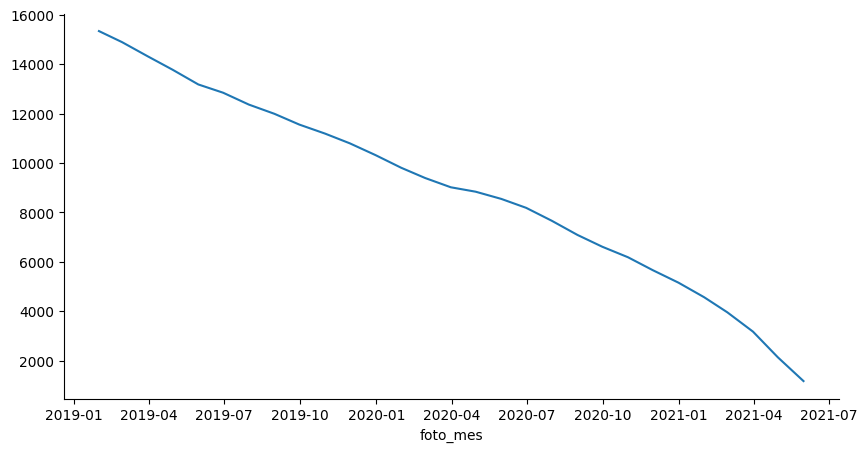

In [452]:
df.groupby(
    ["foto_mes"],
    as_index=True).\
        agg({"numero_de_cliente": "nunique"})["numero_de_cliente"].\
            plot(
                kind="line",
                figsize=(10, 5),
                label="N unique Clients")
plt.show()

In [ ]:
df.groupby(
    ["foto_mes"],
    as_index=True).\
        agg({"numero_de_cliente": "nunique"})["numero_de_cliente"].\
            plot(
                kind="line",
                figsize=(10, 5),
                label="N unique Clients")
plt.show()

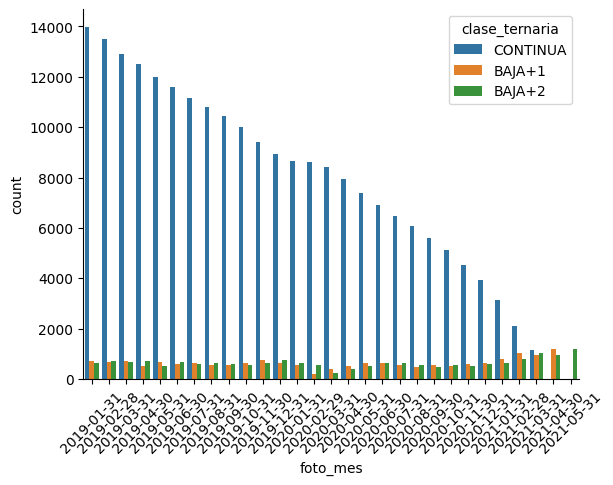

In [457]:
sns.countplot(data=df, x="foto_mes", hue="clase_ternaria")
plt.xticks(rotation=90)
plt.show()

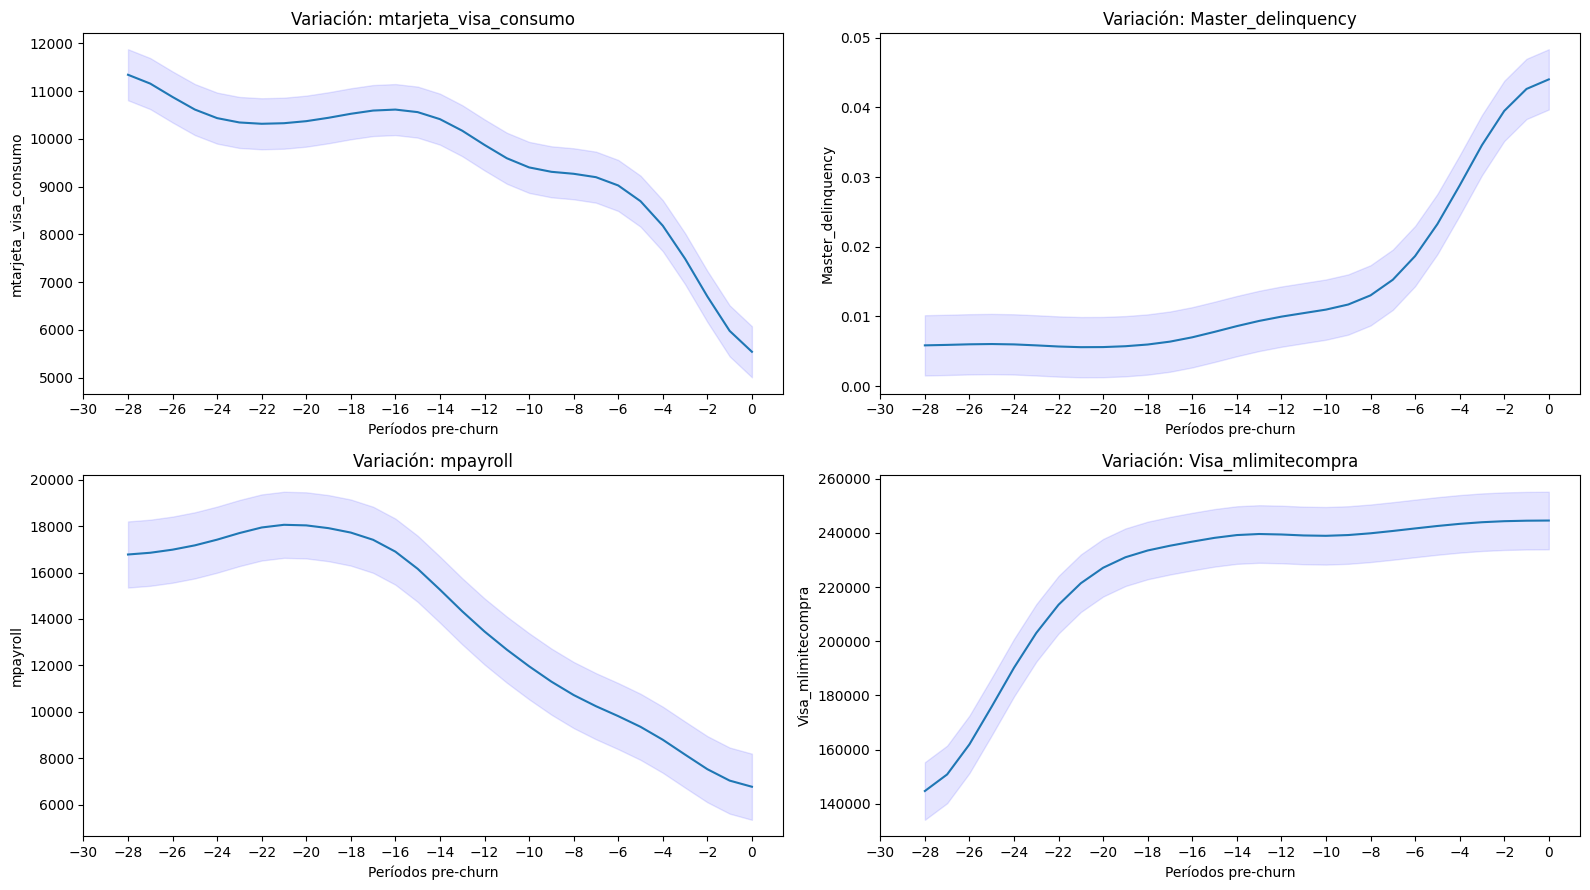

In [152]:
fig, axes = plt.subplots(2, 2, figsize=(16, 9))

axes = axes.flat

for i, col in enumerate(["mtarjeta_visa_consumo", "Master_delinquency", "mpayroll", "Visa_mlimitecompra"]):
    df_temp = df.groupby("rank_foto_mes_2", as_index=False).agg({col: "mean"}).reset_index()
    x = df_temp["rank_foto_mes_2"]
    y = df_temp[col]
    y = gaussian_filter1d(y, sigma=2)
    ci = 1.96 * np.std(y)/np.sqrt(len(x))

    axes[i].plot(x, y, ms=5)
    axes[i].fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

    axes[i].set_title(f"Variación: {col}")
    axes[i].set_xlabel("Períodos pre-churn")
    axes[i].set_ylabel(col)
    axes[i].set_xticks(range(-30,1,2))

plt.tight_layout()
plt.show()

In [153]:
if False:
    for col in df.drop(["foto_mes","clase_ternaria", "numero_de_cliente", "rank_foto_mes"], axis=1).columns:
        fig = plt.figure()
        try:
            df_temp = df.groupby("rank_foto_mes_2", as_index=False).agg({col: "mean"})
            x = df_temp["rank_foto_mes_2"]
            y = df_temp[col]
            y = gaussian_filter1d(y, sigma=2)
            ci = 1.96 * np.std(y)/np.sqrt(len(x))

            plt.plot(x, y, ms=5)
            plt.fill_between(x, (y-ci), (y+ci), color='b', alpha=.1)

            plt.title(f"Variación: {col}")
            plt.xlabel("Períodos pre-churn")
            plt.ylabel(col)
            plt.xticks(range(-30,1,2))

            fig.savefig(f"images/all_time/{col}.png")
            plt.close(fig)
        except Exception as e:
            print(e)
            print(f"Error with {col}")

## Dinamyc Time Warping

In [154]:
df.select_dtypes(exclude=np.number).columns

Index(['tmobile_app', 'cmobile_app_trx', 'clase_ternaria', 'foto_mes'], dtype='object')

In [155]:
if False:
    ts = df.drop(["foto_mes","clase_ternaria", "numero_de_cliente", "rank_foto_mes", 'tmobile_app', 'cmobile_app_trx'], axis=1).set_index("rank_foto_mes_2").fillna(0).sum(axis=1).to_frame("values").reset_index(drop=False)
    ts["numero_de_cliente"] = df["numero_de_cliente"]
    ts = pd.pivot_table(ts,
                        index=["numero_de_cliente"],
                        columns=["rank_foto_mes_2"],
                        values=["values"],
    )
    ts.columns = ts.columns.droplevel(level=0)
    ts = ts.values
    ts = to_time_series_dataset(ts)
    ts_scaled = TimeSeriesScalerMeanVariance().fit_transform(ts)
    print(ts_scaled.shape)

    sum_of_squared_distances = []
    K = range(2,10)
    for k in K:
        print(k)
        km = TimeSeriesKMeans(
            n_clusters=k,
            n_init=2,
            max_iter=5,
            metric="dtw",
            verbose=False,
            max_iter_barycenter=3,
            n_jobs=-1,
            random_state=RANDOM_STATE
        )
        km = km.fit(ts_scaled)
        sum_of_squared_distances.append(km.inertia_)

    plt.plot(K, sum_of_squared_distances, 'bx-')
    plt.xlabel('k')
    plt.ylabel('Sum_of_squared_distances')
    plt.title('Elbow Method For Optimal k')
    plt.show()

    kneedle = KneeLocator(x=range(len(sum_of_squared_distances)), y=sum_of_squared_distances, curve='convex', direction='decreasing')
    kneedle.all_elbows
    print(kneedle.elbow)

## Preprocessing

In [156]:
pca = PCA(random_state=RANDOM_STATE)
scaler = StandardScaler()
kmeans = KMeans(random_state=RANDOM_STATE)
imputer = SimpleImputer(strategy="mean")

In [157]:
df_clust = df.copy()
df_clust= df_clust.drop(["foto_mes", "clase_ternaria", "foto_mes", "rank_foto_mes", "rank_foto_mes_2"],axis=1)
df_clust = df_clust.groupby(["numero_de_cliente"], as_index=False).mean(numeric_only=True)

In [158]:
X_imputed = imputer.fit_transform(df_clust.drop(["numero_de_cliente"], axis=1))
X_imputed = pd.DataFrame(X_imputed, columns=df_clust.drop(["numero_de_cliente"], axis=1).columns)

In [159]:
X_scaled = scaler.fit_transform(X_imputed)
X_scaled = pd.DataFrame(X_scaled, columns=df_clust.drop(["numero_de_cliente"], axis=1).columns)

## Clustering

In [160]:
if False:
    K = range(2,15)
    sum_of_squared_distances = []

    for num_clusters in K :
        kmeans = KMeans(n_clusters=num_clusters, n_init=2, random_state=RANDOM_STATE)
        kmeans.fit(X_scaled)
        sum_of_squared_distances.append(kmeans.inertia_)


    kneedle = KneeLocator(x=range(len(sum_of_squared_distances)), y=sum_of_squared_distances, curve='convex', direction='decreasing')
    knee = kneedle.elbow
    print(knee)

    plt.plot(K, sum_of_squared_distances,'bx-')
    plt.plot(knee, sum_of_squared_distances[knee-2], 'ro')
    plt.xlabel('Values of K')
    plt.ylabel('Sum of squared distances/Inertia')
    plt.title('Elbow Method For Optimal k')
    plt.show()

In [161]:
if False:
    mlflow.sklearn.autolog()
    mlflow.set_experiment("Cluster")

    with mlflow.start_run():
        kmeans = KMeans(n_clusters=knee, random_state=RANDOM_STATE)
        kmeans.fit(X_scaled)
    mlflow.end_run()
else:
    logged_model = 'runs:/e38db5bd2e8a4939840c829bb01bec88/model'
    kmeans = mlflow.sklearn.load_model(logged_model)

In [162]:
knee = kmeans.n_clusters

## PCA

In [163]:
X_pca = pca.fit_transform(X_scaled)
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

In [164]:
loading_matrix = pd.DataFrame(loadings, columns=[f"PC{i}" for i in range(X_scaled.shape[1])], index=list(df_clust.drop(["numero_de_cliente"], axis=1).columns))
loading_matrix["PC0"] = loading_matrix["PC0"].abs()
loading_matrix.sort_values(by="PC0", ascending=False).head(30)

,PC0,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20,PC21,PC22,PC23,PC24,PC25,PC26,PC27,PC28,PC29,PC30,PC31,PC32,PC33,PC34,PC35,PC36,PC37,PC38,PC39,PC40,PC41,PC42,PC43,PC44,PC45,PC46,PC47,PC48,PC49,PC50,PC51,PC52,PC53,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,PC62,PC63,PC64,PC65,PC66,PC67,PC68,PC69,PC70,PC71,PC72,PC73,PC74,PC75,PC76,PC77,PC78,PC79,PC80,PC81,PC82,PC83,PC84,PC85,PC86,PC87,PC88,PC89,PC90,PC91,PC92,PC93,PC94,PC95,PC96,PC97,PC98,PC99,PC100,PC101,PC102,PC103,PC104,PC105,PC106,PC107,PC108,PC109,PC110,PC111,PC112,PC113,PC114,PC115,PC116,PC117,PC118,PC119,PC120,PC121,PC122,PC123,PC124,PC125,PC126,PC127,PC128,PC129,PC130,PC131,PC132,PC133,PC134,PC135,PC136,PC137,PC138,PC139,PC140,PC141,PC142,PC143,PC144,PC145,PC146,PC147,PC148,PC149
mtarjeta_visa_consumo,0.761165,-0.200796,-0.162173,0.224633,-0.066487,-0.164519,0.300850,0.093330,-0.085069,0.040845,-0.139956,-0.036265,0.120688,-0.009882,-0.015284,0.041757,-0.030542,-0.011592,0.021497,-0.046402,0.013326,0.000784,-0.002603,0.003755,-0.022383,-0.021321,-0.055927,0.034078,-0.012619,-0.020012,0.013879,0.027997,0.010737,-0.020886,-0.033433,0.010012,-0.041635,-0.011143,-0.011548,0.035140,-0.022158,-0.025820,-0.024371,-0.026588,-0.008576,-0.014744,0.004680,-0.026041,-0.017110,-0.029852,-0.006143,0.032306,-0.012331,0.054120,0.014505,0.035322,0.015658,0.021876,0.032886,-0.027153,-0.003356,0.005545,-0.003075,0.019228,0.021683,-0.022723,0.016526,-0.047705,-0.012972,0.040335,0.013246,-0.011874,0.020812,-0.015810,0.004797,-0.040943,0.047841,-0.017830,-0.008678,0.030397,-0.011357,-0.061774,0.012498,0.018854,0.045134,-0.016215,-0.024051,-0.010220,-0.002195,0.003836,0.004317,-0.004430,0.030282,-0.021789,0.057866,-0.072535,-0.008413,-0.051392,-0.028533,-0.012863,0.044025,-0.037600,-0.045220,-0.037201,0.053316,0.065627,-0.000202,0.044069,-0.065470,-0.023328,0.011739,0.033852,-0.016881,-0.013394,-0.015052,-0.081520,0.055954,0.015249,-0.000001,0.010419,0.025184,0.002702,0.013617,-0.020927,-0.003827,0.017255,-0.017024,0.100449,0.005228,-0.018752,0.034760,-0.018124,0.002539,0.007169,0.018692,-0.010014,-0.010062,0.036784,0.126888,-0.001795,-0.003276,8.678477e-07,-4.453702e-08,4.527089e-09,-8.388061e-10,8.192626e-32,2.411117e-33,1.385426e-31,-1.380443e-32,2.080873e-31
ctrx_quarter,0.739174,-0.125681,0.332646,-0.249368,-0.032006,-0.151685,0.086566,-0.066547,0.110899,0.045725,0.029913,0.069033,0.064767,0.083865,0.058188,-0.076620,-0.006806,-0.013881,0.056972,-0.043720,-0.065323,0.051117,0.020529,-0.034252,-0.020545,0.025727,-0.001956,0.026937,-0.002915,-0.039594,-0.008514,0.020057,0.029116,0.075545,-0.006129,0.047342,0.054277,-0.050432,-0.002455,0.063591,0.118192,0.057332,0.000259,0.084650,0.052135,0.035270,-0.069089,0.048926,-0.015561,0.018338,0.002734,-0.038580,-0.018716,-0.030077,-0.033538,-0.062275,-0.010983,-0.015974,0.023162,-0.041205,0.035633,0.013569,0.000285,0.005509,-0.008393,-0.050391,-0.029910,0.011430,0.062603,0.001091,0.010569,0.017779,0.021826,-0.032824,0.017502,0.042985,-0.016324,-0.025369,0.039268,-0.001375,0.003155,-0.010335,-0.005402,0.004535,-0.022215,0.022066,-0.039174,0.038572,-0.024843,0.028443,0.039114,-0.023777,0.010691,-0.040898,0.008900,-0.026306,0.008710,0.012835,-0.004293,-0.001257,0.017530,-0.010606,0.012812,0.012187,0.010922,0.035644,-0.006725,-0.018850,0.014574,-0.027290,-0.055671,0.014340,-0.011678,0.009251,-0.015837,-0.007799,-0.030126,-0.073092,-0.058900,0.085108,-0.025731,0.076136,-0.021297,-0.011226,-0.011217,-0.018000,-0.046927,-0.005652,0.033839,0.019318,-0.068921,-0.022885,0.193618,-0.013371,0.035549,-0.005917,-0.003086,-0.005713,-0.002597,0.001503,0.000021,-7.109475e-07,-5.375183e-08,-1.282876e-09,-6.825607e-10,-5.401148e-32,2.017151e-32,-4.740424e-32,-5.076261e-32,4.111849e-32
Visa_mconsumototal,0.688716,-0.179957,-0.254866,0.306842,0.083675,-0.094546,0.366999,0.109385,-0.093485,0.036461,-0.070115,-0.084310,0.139242,0.014080,-0.055843,0.086866,-0.002550,-0.022867,0.060200,-0.010731,-0.001960,-0.008082,-0.031146,0.01

In [165]:
fig, axes = plt.subplots(1,3, figsize=(15,5))

axes = axes.flat

sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=kmeans.predict(X_scaled), ax=axes[0])
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,2], hue=kmeans.predict(X_scaled), ax=axes[1])
sns.scatterplot(x=X_pca[:,1], y=X_pca[:,2], hue=kmeans.predict(X_scaled), ax=axes[2])
plt.tight_layout()

In [166]:
if False:
    mlflow.sklearn.autolog()
    mlflow.set_experiment("Classifier")

    with mlflow.start_run():
        rf = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
        rf.fit(X_scaled, kmeans.predict(X_scaled))
        model_info = mlflow.sklearn.log_model(rf, "model")
        eval_data = X_scaled.copy()
        eval_data["target"] = kmeans.predict(X_scaled)

        mlflow.evaluate(
            model_info.model_uri,
            data=eval_data,
            targets="target",
            model_type="classifier",
            evaluators="default",
            evaluator_config={
                "explainability_algorithm": "permutation",
                "metric_prefix": "evaluation_"
            },
        )
else:
    logged_model = 'runs:/d989ac3a52bb47999baf8c523498d392/model'
    rf = mlflow.sklearn.load_model(logged_model)

In [167]:
forest_importances = pd.Series(rf.feature_importances_, index=X_scaled.columns)

In [168]:
forest_importances.sort_values(ascending=False).head(10)

Visa_status                 0.064587
ctarjeta_visa               0.061338
ctrx_quarter                0.049607
cdescubierto_preacordado    0.042554
cextraccion_autoservicio    0.039855
mextraccion_autoservicio    0.037660
ctarjeta_master             0.032767
catm_trx                    0.030623
Master_status               0.027540
Visa_mpagominimo            0.025495
dtype: float64

## Explanations

In [169]:
import mlflow
import shap
import pickle
from sklearn.model_selection import train_test_split

In [170]:
if False:
    explainer = mlflow.shap.load_explainer('runs:/d989ac3a52bb47999baf8c523498d392/explainer')
    shap_values = explainer(X_scaled)
    pickle.dump(shap_values, open("shap_values/explainer.pkl", "wb"))
else:
    shap_values = pickle.load(open("shap_values/explainer.pkl", "rb"))

In [171]:
type(shap_values)

shap._explanation.Explanation

In [172]:
y_pred = kmeans.predict(X_scaled)

In [468]:
if True:
    for i in range(0,knee):
        plt.figure()
        shap.plots.violin(
            shap_values[y_pred==i],
            show=False,
            max_display=20,
            plot_type="layered_violin",
        )
        plt.savefig(f"images/shap/violin_plot_{i}.png", bbox_inches='tight')

        plt.figure()
        shap.plots.bar(
            shap_values[y_pred==i],
            show=False,
            max_display=20,
        )
        plt.savefig(f"images/shap/bar_plot_{i}.png", bbox_inches='tight')


        plt.figure()
        shap.plots.waterfall(
            shap_values[y_pred==i][0],
            show=False,
            max_display=20
        )
        plt.savefig(f"images/shap/waterfall_plot{i}.png", bbox_inches='tight')

In [460]:
df_clust_time = df.copy()
df_clust_time = df_clust_time.merge(df_clust[["numero_de_cliente", "cluster"]], on="numero_de_cliente", how="left")

In [461]:
cluster_to_simpson = {
    0: "Acné guy",
    1: "Lenny",
    2: "Flanders",
    3: "Skinner",
    4: "Moe",
    5: "Real Skinner"
    }

In [462]:
df_clust_time["cluster"] = df_clust_time["cluster"].map(cluster_to_simpson)

## Analisis de cluster vs los demás

In [470]:
clust_cols = [
    ["mextraccion_autoservicio", "mpayroll", "mautoservicio", "cpayroll_trx", "ctarjeta_debito_transacciones"],
    ["Visa_status","Visa_msaldototal", "mtarjeta_visa_consumo", "Visa_mconsumospesos", "Visa_mpagominimo"],
    ["ctarjeta_visa", "ctarjeta_master", "Master_status", "Visa_status","Visa_mpagominimo", "mtarjeta_visa_consumo", "mprestamos_personales", "Visa_delinquency"],
    ["mcomisiones_otras", "mcomisiones", "mrentabilidad"],
    ["mtarjeta_visa_consumo", "Visa_mpagominimo", "mtarjeta_master_consumo", "Master_mpagominimo"],
    ["mcomisiones", "mpasivos_margen", "Visa_msaldototal", "Visa_mconsumospesos", "mrentabilidad"],
]

for i in range(len(clust_cols)):
    for col in clust_cols[i]:
        fig = plt.figure()
        df_temp = df_clust_time[df_clust_time["cluster"]==cluster_to_simpson[i]].groupby("rank_foto_mes_2", as_index=False).agg({col: "mean"})
        x = df_temp["rank_foto_mes_2"]
        y = df_temp[col]
        y = gaussian_filter1d(y, sigma=1.8)
        ci = 1.96 * np.std(y)/np.sqrt(len(x))

        plt.plot(x, y, ms=5, color=f"C{i}", label = f"{cluster_to_simpson[i]}")
        plt.fill_between(x, (y-ci), (y+ci), color=f"C{i}", alpha=.1)

        df_temp = df_clust_time[~(df_clust_time["cluster"]==cluster_to_simpson[i])].groupby("rank_foto_mes_2", as_index=False).agg({col: "mean"})
        x = df_temp["rank_foto_mes_2"]
        y = df_temp[col]
        y = gaussian_filter1d(y, sigma=1.8)
        ci = 1.96 * np.std(y)/np.sqrt(len(x))

        plt.plot(x, y, ms=5, color=f"C6", label = f"Otros")
        plt.fill_between(x, (y-ci), (y+ci), color=f"C6", alpha=.1)

        plt.title(f"Variación: {col}")
        plt.xlabel("Períodos pre-churn")
        plt.ylabel(col)
        plt.legend()
        plt.xticks(range(-30,1,3))
        fig.savefig(f"images/cluster/{i}/{col}.png", transparent=True)
        plt.close(fig)


## Clústers todos contra todos

In [446]:
clust_cols = ["ctrx_quarter", "mpayroll", "cdescubierto_preacordado", "Visa_status",
              "mpasivos_margen", "mcomisiones","mrentabilidad"
              ]
for col in clust_cols:
    fig = plt.figure()
    for i,simpson in enumerate(sorted(list(df_clust_time["cluster"].unique()))):
        df_temp = df_clust_time[df_clust_time["cluster"]==i].groupby("rank_foto_mes_2", as_index=False).agg({col: "mean"})
        x = df_temp["rank_foto_mes_2"]
        y = df_temp[col]
        y = gaussian_filter1d(y, sigma=2)
        ci = 1.96 * np.std(y)/np.sqrt(len(x))

        plt.plot(x, y, ms=5, color=f"C{i}", label = f"{simpson}")
        plt.fill_between(x, (y-ci), (y+ci), color=f"C{i}", alpha=.1)

        plt.title(f"Variación: {col}")
        plt.xlabel("Períodos pre-churn")
        plt.ylabel(col)

    plt.xticks(range(-30,1,3))
    plt.legend()
    fig.savefig(f"images/cluster/all/{col}.png", transparent=True)
    plt.close(fig)

## Clusters - Bubbles

In [389]:
np.random.seed(RANDOM_STATE)
cluster_bubbles = pd.Series(y_pred).value_counts().to_frame("count").reset_index(drop=False).rename(columns={"index": "cluster"})
cluster_bubbles["x"] = np.random.randint(-5, 5, cluster_bubbles.shape[0])
cluster_bubbles["y"] = np.random.randint(-5, 5, cluster_bubbles.shape[0])

In [390]:
cluster_bubbles

,cluster,count,x,y
0,1,10718,1,-3
1,2,3413,-2,1
2,0,2945,2,2
3,4,1409,-1,-1
4,5,78,1,-2
5,3,32,4,2


In [398]:
cluster_bubbles.loc[4,"x"] =4
cluster_bubbles.loc[4,"y"] =0

In [421]:
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

fig = sns.scatterplot(x="x", y="y", data=cluster_bubbles, size="count",sizes=(1000,10000), hue='cluster', palette="Set2", legend=False)
fig.set_xlim(-3,5)
fig.set_ylim(-5,3)
plt.xticks([])
plt.yticks([])
plt.savefig(f"images/cluster/all/bubbles.png", bbox_inches='tight', transparent=True)